In [1]:
run ='waom10'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data_xmd','preprocessing')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)
from tools.NDinterp import NDinterp
from tools.log_progress import log_progress

T_mask_path = os.path.join(data_dir,'external_xmd','tamura','EASE_landmask_H.data')
T_lat_lon_path = os.path.join(data_dir,'external_xmd','tamura','latlon.data')
T_data_path = os.path.join(data_dir,'external_xmd','tamura','daily')
era_path = os.path.join(data_dir,'external_xmd','era_interim','ERA_Interim_1992_2016_1daily.u10.v10.nc')
R_grid_path = os.path.join(data_dir,'processed_xmd',run+'_grd.nc')

In [2]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

In [3]:
#read in tamura land mask
with open(T_mask_path,'rb') as fid:
    T_mask = np.fromfile(fid,count=(721*721),dtype='float32').reshape((721,721))
    T_mask = np.flipud(T_mask)

In [4]:
#get tamura lat lon coordinates
with open(T_lat_lon_path,'rb') as fid:
    T_lat_lon = np.fromfile(fid,count=(721*721*2),dtype='float32').reshape((2,721,721))
T_lat,T_lon = (T_lat_lon[0],T_lat_lon[1])
T_lat = np.flipud(T_lat)
T_lon = np.flipud(T_lon)
T_lon[T_lon<0]+=360

In [5]:
#read in era interim winds and resample from twice daily to daily
era_ds = xr.open_mfdataset(era_path,data_vars='minimal').sel(time='1997',latitude=slice(-30,-90))

#get era coordinates
era_lon,era_lat = era_ds.longitude.values,era_ds.latitude.values
era_lon_2d,era_lat_2d = np.meshgrid(era_lon,era_lat)

In [6]:
#define regridding functions for era and tamura data
# griddata takes flat arrays of source points and data and interpolates to 2d grid
        

def regrid_tamura(slon,slat,sdat,tlon,tlat):
    
    slon = slon[slat<(tlat.max()+2)] # only load data up to 2 deg further north of roms highest latitude
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]
    
    #tamura comes from npstereo curvilinear grid
    #we need to find points close to the 0/360 gap, wrap them and add them to the list for source points
    # otherwise we get an interpolation gap between 0/360
    
    ii1 = (slon<2.0)

    slon_ext1 = slon[ii1]
    slon_ext1[slon_ext1<=1]+=360

    ii2 = (slon>358.0)

    slon_ext2 = slon[ii2]
    slon_ext2[slon_ext2>=359]-=360
    
    slon_ext = np.hstack((slon_ext1,slon_ext2))
    slat_ext = np.hstack((slat[ii1],slat[ii2]))
    sdat_ext = np.hstack((sdat[ii1],sdat[ii2]))
      
    slon = np.hstack((slon,slon_ext))
    slat = np.hstack((slat,slat_ext))
    sdat = np.hstack((sdat,sdat_ext))

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
    
    return tdat

In [7]:
# era is more easy, since its on a mercator projection
# we just have to extend the arrays at the beginning and end to bridge the gap at 0/360

def regrid_era(slon_raw,slat,sdat_raw,tlon,tlat):
    
    slon = np.zeros(np.size(slon_raw)+2)
    slon[0] = slon_raw[-1]-360
    slon[1:-1] = slon_raw[:]
    slon[-1] = slon_raw[0]+360

    slon, slat = np.meshgrid(slon,slat)
    
    sdat = np.zeros((np.size(sdat_raw,0),np.size(sdat_raw,1)+2))
    sdat[:,0] = sdat_raw[:,-1]
    sdat[:,1:-1] = sdat_raw[:,:]
    sdat[:,-1] = sdat_raw[:,0]
    
    slon = slon[slat<(tlat.max()+2)]
    sdat = sdat[slat<(tlat.max()+2)]
    slat = slat[slat<(tlat.max()+2)]

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat

In [1]:
# MAKE THE MAGIC HAPPEN FOR 2007 AND save in interim folder
years = [slice('1996','1998')]
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
for year in years:
  mod = year%4
  if mod==0:
     daysPerMonth = [31,29,31,30,31,30,31,31,30,31,30,31]
  else:
     daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [31]

dayOfYear = 1

for years,month,days,month_nb in zip(years,month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    #open Tamura month flux data 
    T_month_path = os.path.join(T_data_path,'TSDM2hb_1997_'+month+'.data')
    with open(T_month_path,'rb') as fid:
        T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        
        #read in Tamura heat and fresh water flux and turn in right position
        shflux_tmp = np.flipud(T_data[0,Tidx])
        ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        #fill in tamuar mask for later resampling
        shflux_tmp[T_mask==0] = np.nan
        shflux_tmp = NDinterp(shflux_tmp)
        
        ssflux_tmp[T_mask==0] = np.nan
        ssflux_tmp = NDinterp(ssflux_tmp)
        
        shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        
        shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4

        ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        del ssflux_tmp
        
        #select era-interim winds
        uwnd = era_ds.u10[Eidx].values
        vwnd = era_ds.v10[Eidx].values
        
        #rotate wind directions to roms grid
        uv = (uwnd+1j*vwnd)*np.exp(1j*-(era_lon_2d/180*np.pi))
        uwnd = uv.real
        vwnd = uv.imag
        
        
        uwnd = regrid_era(era_lon,era_lat,uwnd,R_ulon,R_ulat)
        vwnd = regrid_era(era_lon,era_lat,vwnd,R_vlon,R_vlat)
        
        
        #convert to stress
        signu = np.sign(uwnd)
        signv = np.sign(vwnd)

        rhoAir = 1.3
        Cd = 1.4e-3

        taux = rhoAir*Cd*np.square(uwnd)*signu
        tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uwnd, vwnd
        
        ds.sustr[Tidx]= taux#taux_smooth*fac
        ds.svstr[Tidx]= tauy#tauy_smooth*fac
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'tamura_file':T_data_path,
                          'era-interim file':era_path,
                          'grid file':R_grid_path,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        int_path = os.path.join(data_dir,'interim_xmd',run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+int_path)
        ds[var].to_netcdf(int_path,'w',unlimited_dims=dim)
    #del ds
    
    #update the day of the year value for next month
    dayOfYear += days

SyntaxError: invalid syntax (<ipython-input-1-9f293818d34a>, line 5)

In [ ]:
#collect all interim results, merge to yearly data amd adjust cycle length attribute
#save forcing files in processed folder
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(data_dir,'interim',run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(data_dir,'processed_xmd',run+'_'+var+'.nc')
    print('saving final to'+out_path)
    ds.to_netcdf(out_path,'w')

# below just devel stuff

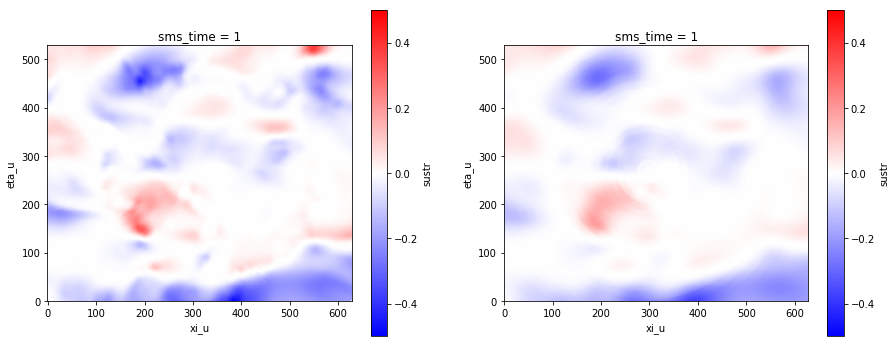

In [54]:
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.sustr.plot(ax=ax0,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
old.sustr[0].plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


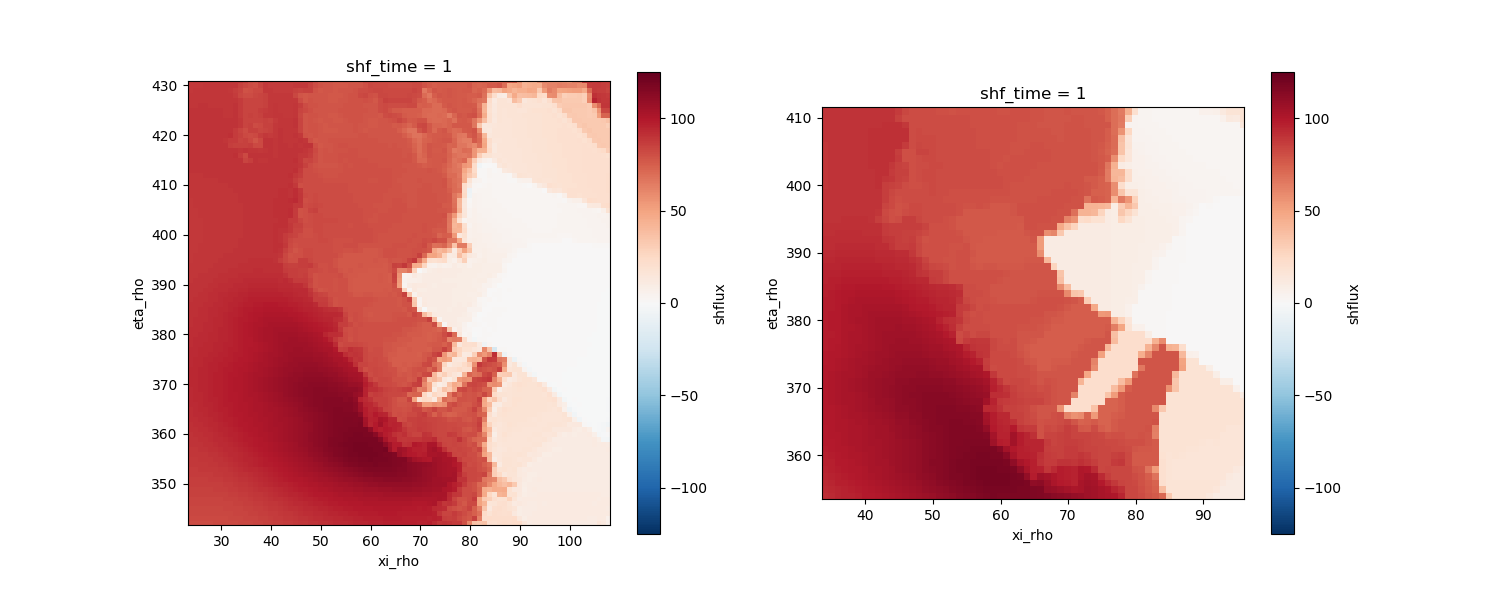

In [58]:
%matplotlib notebook
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.shflux.plot(ax=ax0)
old_shflx.shflux[0].plot(ax=ax1)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [56]:
path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_sustr.nc')
old_sustr = xr.open_dataset(path)

path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_shflux.nc')
old_shflx = xr.open_dataset(path)